### Imports

In [1]:
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoModel, AutoTokenizer

from transformers import TrainingArguments, Trainer

2025-07-07 19:43:29.401927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751917409.595440      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751917409.651840      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install -U datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.4.0.6 which is incompatible.
torch 2.6.0+

In [3]:
!pip install trl -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00:00:0100:01


In [4]:
from trl import RewardConfig, RewardTrainer, SFTConfig, SFTTrainer
from peft import LoraConfig, TaskType

In [5]:
from datasets import Dataset, load_dataset, concatenate_datasets

In [6]:
from tqdm import tqdm

In [7]:
import gc

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.distributions.categorical import Categorical

torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
from copy import deepcopy

In [11]:
import warnings
warnings.filterwarnings('ignore')

### Config

In [12]:
path_to_original_model = 'HuggingFaceTB/SmolLM-135M'

dataset_name = 'juyoungml/HelpSteer2-binarized'

save_folder = './kaggle/working/'

batch_size=16
max_length=256

lr=5e-5
num_train_epochs=1

peft_config = LoraConfig(task_type=TaskType.SEQ_CLS,)

num_labels=10

loss_fn = nn.CrossEntropyLoss()

### Utils

In [13]:
def preprocess_ds(ds):

    """
    Preprocess function for Dataset

    Args:
        ds: dataset to preprocess (datasets.Dataset)

    Returns:
        Preprocessed line from ds for RewardTrainer
    """

    chosen = zip(ds['prompt'], ds['chosen'])
    chosen = list(map(lambda x: 'Prompt: '+x[0]+'\nEnding: '+x[1], chosen))

    rejected = zip(ds['prompt'], ds['rejected'])
    rejected = list(map(lambda x: 'Prompt: '+x[0]+'\nEnding: '+x[1], rejected))

    chosen_tok = tokenizer(chosen, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    rejected_tok = tokenizer(rejected, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

    return {'input_ids_chosen':chosen_tok['input_ids']
          , 'attention_mask_chosen':chosen_tok['attention_mask']
          , 'input_ids_rejected':rejected_tok['input_ids']
          , 'attention_mask_rejected':rejected_tok['attention_mask']}

In [14]:
def preprocess_ds_for_multi(ds, ending_type):
    """
    Preprocess function for Dataset

    Args:
        ds: dataset to preprocess (datasets.Dataset)
        ending_type: 'chosen' or 'rejected' (str)

    Returns:
        Preprocessed line from ds with ground truth class of the reward 
    """

    texts = zip(ds['prompt'], ds[ending_type])
    texts = list(map(lambda x: 'Prompt: '+x[0]+'\nEnding: '+x[1], texts))
    
    if ending_type=='chosen':
        return {'text':texts
            , 'labels':[int(5+i) for i in ds[ending_type+'_score']]}
    
    if ending_type=='rejected':
        return {'text':texts
            , 'labels':[int(5-i) for i in ds[ending_type+'_score']]}


In [15]:
def normal_categorical(target, sigma=1.0, n_classes=num_labels):
    """
    Returns categorical probabilities shaped like a normal distribution
    centered at target over classes [0, 1, ..., n_classes-1]

    Args:
        target: Center of distribution (float)
        sigma: Spread parameter (float > 0)
        n_classes: Number of categories (int)

    Returns:
        np.array: Probability distribution over classes
    """
    # Generate class indices
    classes = torch.arange(n_classes)

    # Calculate unnormalized probabilities (normal PDF)
    unnormalized = torch.exp(-(classes - target)**2 / (2 * sigma**2))

    # Normalize to sum=1
    probs = unnormalized / unnormalized.sum()
    return probs

In [16]:
def preprocess_ds_for_multi_distribution(ds, ending_type):

    """
    Preprocess function for Dataset

    Args:
        ds: dataset to preprocess (datasets.Dataset)
        ending_type: 'chosen' or 'rejected' (str)

    Returns:
        Preprocessed line from ds with distribution of rewards centered around ground truth reward score
    """

    texts = zip(ds['prompt'], ds[ending_type])
    texts = list(map(lambda x: 'Prompt: '+x[0]+'\nEnding: '+x[1], texts))
    # rejected = zip(ds['prompt'], ds['rejected'])

    # chosen_tok = tokenizer(chosen, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    # rejected_tok = tokenizer(list(rejected), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

    texts_score_distribution = [normal_categorical(i) for i in ds[ending_type+'_score']]

    return {'text':texts
          , 'labels':normal_categorical(torch.vstack(texts_score_distribution))}

          # 'input_ids':chosen_tok['input_ids']
          # , 'attention_mask':chosen_tok['attention_mask']

In [17]:
def evaluate_models(model_to_score, data_loader):
    evals = []
    for line in tqdm(data_loader):
        generated_logits = model_to_score(**tokenizer(line['prompt']
                                                      , padding=True
                                                      , truncation=True
                                                      , max_length=max_length
                                                      , return_tensors='pt').to(device))
        generated_texts = tokenizer.batch_decode(generated_logits.logits.argmax(dim=-1))
        generated_reward_tok = tokenizer(generated_texts
                                      , padding=True
                                      , truncation=True
                                      , max_length=max_length
                                      , return_tensors='pt').to(device)
        generated_rewards = nn.functional.softmax(reward_model(**generated_reward_tok).logits, dim=-1)[:, 1]
        evals += generated_rewards.tolist()
    return evals

In [18]:
def clear_cache():
    torch.cuda.empty_cache()
    gc.collect()

### Dataset+tokenizer

In [19]:
ds = load_dataset(dataset_name)

train_ds = ds['train']
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = ds['validation']
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/13.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/708k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7224 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/373 [00:00<?, ? examples/s]

In [20]:
# same tokenizer for all instances
tokenizer = AutoTokenizer.from_pretrained(path_to_original_model
                                              , trust_remote_code=True
                                             , device_map='auto')
#

tokenizer.pad_token = 'PAD'

tokenizer.padding_side='left'

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

In [21]:
# to compare with finetuned models
frozen_model = AutoModelForCausalLM.from_pretrained(path_to_original_model
                                              , trust_remote_code=True
                                             , device_map='auto')
frozen_model.eval()

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb): LlamaRotaryEm

### Reward model training

In [22]:
model_for_reward_tuning = AutoModelForSequenceClassification.from_pretrained(path_to_original_model
                                              , trust_remote_code=True
                                             , device_map='auto')
#
model_for_reward_tuning.config.pad_token_id = model_for_reward_tuning.config.eos_token_id

r_config = RewardConfig(output_dir='smollm-rm'
                        , fp16=True
                        , learning_rate=lr
                        , num_train_epochs=num_train_epochs
                        , per_device_train_batch_size=batch_size
                        , report_to='none'
                        , max_length=max_length
                        , eval_strategy='epoch'
                        , logging_strategy='epoch')
r_trainer = RewardTrainer(model=model_for_reward_tuning
                          , args=r_config
                          , train_dataset=train_ds.map(preprocess_ds, batched=True, remove_columns=train_ds.column_names)
                          , eval_dataset=valid_ds.map(preprocess_ds, batched=True, remove_columns=train_ds.column_names)
                          , peft_config=peft_config
                          , processing_class=tokenizer)
r_trainer.train()

r_trainer.save_model(save_folder+"smollm-rm")

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
average_tokens_across_devices is set to True but it is invalid when world size is1. Turn it to False automatically.


Map:   0%|          | 0/7224 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.755500,0.727585,0.520755


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Prompt:                                       │ Prompt:                                      │ [0.5, 0.5]       │
│  Is it possible to host data on a satellite?  │  Is it possible to host data on a satellite? │                  │
│ <extra_id_1>Assistant                         │ <extra_id_1>Assistant                        │                  │
│ Yes, it’s possible to host data on a          │ Yes, it’s possible to host data on a         │                  │
│ satellite. Satellites can carry computer      │ satellite. Satellites can carry computer     │                  │
│ servers and other electronic equipment, so    │ servers and other electronic equipment, so   │                  │
│ it’s possible to store and transmit data via  │ it’s possible to store and transmit data via │                  │
│ satellite. This is often used for remote data │ satellite. This is often used for remote     │                  │
│ storage and backup, as well as for internet   │ data storage and backup, as well as for      │                  │
│ and telecommunications services.              │ internet and telecommunications services.    │                  │
│ Satellite-hosted data is relatively secure,   │ Satellite-hosted data is relatively secure,  │                  │
│ as it’s not vulnerable to terrestrial threats │ as it’s not vulnerable to terrestrial        │                  │
│ like natural disasters or hacking, and it can │ threats like natural disasters or hacking,   │                  │
│ be accessed from anywhere on the globe.       │ and it can be accessed from anywhere on the  │                  │
│ <extra_id_1>User                              │ globe.                                       │                  │
│ Does hosting data on a satellite ensure that  │ <extra_id_1>User                             │                  │
│ governments and corporations will be unable   │ Does hosting data on a satellite ensure that │                  │
│ to acess the servers?                         │ governments and corporations will be unable  │                  │
│ <extra_id_1>Assistant                         │ to acess the servers?                        │                  │
│ Hosting data on a satellite does help ensure  │ <extra_id_1>Assistant                        │                  │
│ privacy and security, as satellite data       │ Hosting data on a satellite does help ensure │                  │
│ hosting services are often located in         │ privacy and security, as satellite data      │                  │
│ jurisdictions with strong privacy laws, and   │ hosting services are often located in        │                  │
│ are physically isolated from terrestrial      │ jurisdictions with strong privacy laws, and  │                  │
│ threats like hacking and natural disasters.   │ are physically isolated from terrestrial     │                  │
│ However, there is still some risk of          │ threats like hacking and natural disasters.  │                  │
│ unauthorized access to satellite-hosted data, │ However, there is still some risk of         │                  │
│ as satellites are vulnerable to attack from   │ unauthorized access to satellite-hosted      │                  │
│ space-based threats like orbital debris and   │ data, as satellites are vulnerable to attack │                  │
│ solar flares. In addition, governments and    │ from space-based threats like orbital debris │                  │
│ corporations may still be able to access      │ and solar flares. In addition, governments   │                  │
│ satellite-hosted data via legal means, such   │ and co

In [23]:
with torch.no_grad():
    del model_for_reward_tuning
    clear_cache()

#### finetune with reward model

In [24]:
reward_model = AutoModelForSequenceClassification.from_pretrained(save_folder+'smollm-rm', trust_remote_code=True, device_map='auto')
reward_model.config.pad_token_id = reward_model.config.eos_token_id
reward_model.eval()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=576, out_features=576, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=576, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=576, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): lora.Linear(
            (base_layer): Linear(in_features=576, out_features=192, bias=False)
    

In [25]:
ref_model = deepcopy(frozen_model)
ref_model.config.pad_token_id = ref_model.config.eos_token_id
ref_model.train()
#

optimizer = torch.optim.Adam(ref_model.parameters(), lr=lr)

In [26]:
prev_scores = []

for epoch in range(num_train_epochs):
    for line in tqdm(train_dl):
        optimizer.zero_grad()
        x = tokenizer(line['prompt'], padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)

        y_pred = ref_model(**x, output_scores=True).logits
        y_pred = nn.functional.log_softmax(y_pred, dim=-1)

        y_pred_sequences = y_pred.argmax(dim=-1)
        y_pred_texts = tokenizer.batch_decode(y_pred_sequences, skip_special_tokens=True)

        reward_tok = tokenizer(y_pred_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        y_pred_rewards = torch.softmax(reward_model(**reward_tok).logits, dim=-1)[:, 1]
        prev_scores += y_pred_rewards.tolist()

        y_pred_rewards -= sum(prev_scores)/len(prev_scores) ### subtracting baseline from current rewards

        gathered_scores = torch.gather(y_pred, dim=2, index=y_pred_sequences[:, :len(y_pred)].T.unsqueeze(-1)).squeeze(-1)

        loss = torch.sum(gathered_scores, dim=-1)*y_pred_rewards

        loss.sum().backward()
        optimizer.step()

        with torch.no_grad():
            clear_cache()


100%|██████████| 452/452 [11:50<00:00,  1.57s/it]


In [27]:
with torch.no_grad():
    all_frozen_rewards = evaluate_models(frozen_model, valid_dl)
    all_fitted_rewards = evaluate_models(ref_model, valid_dl)

100%|██████████| 24/24 [00:09<00:00,  2.59it/s]


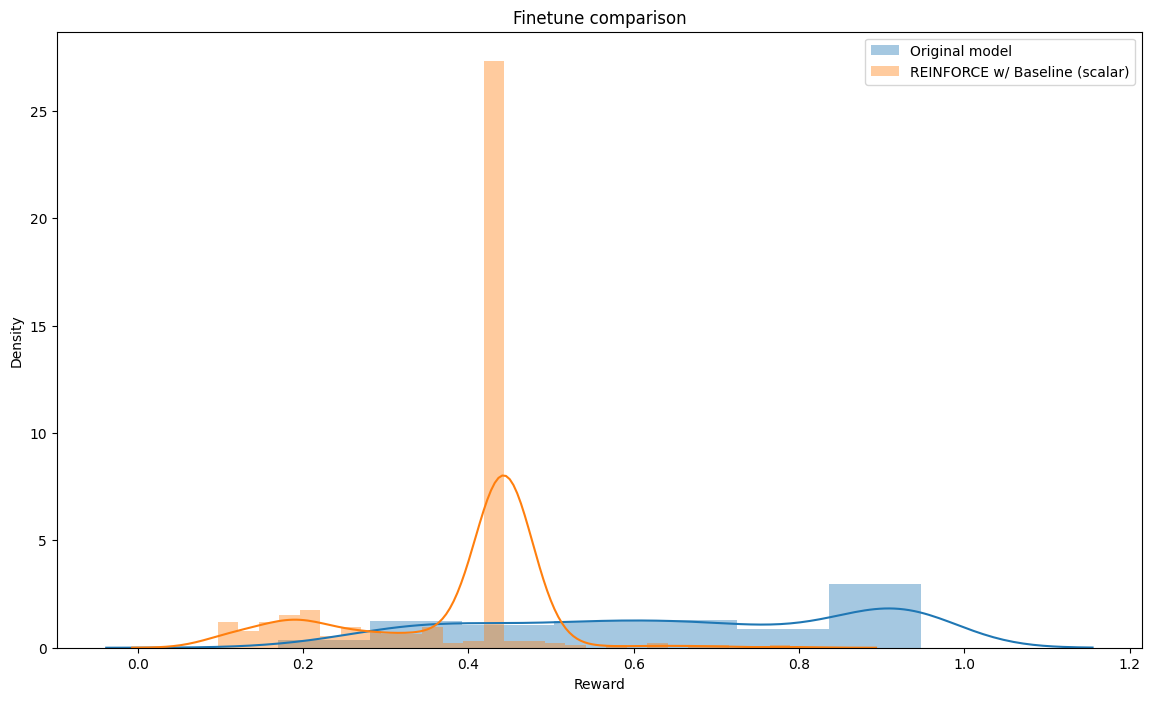

In [28]:
fig, ax = plt.subplots(figsize=(14,8))
sns.distplot(all_frozen_rewards, label='Original model')
sns.distplot(all_fitted_rewards, label='REINFORCE w/ Baseline (scalar)')
plt.title('Finetune comparison')
plt.xlabel('Reward')
plt.legend()
plt.show()

In [29]:
with torch.no_grad():
    del ref_model
    clear_cache()

### Multiclass reward model

In [30]:
train_chosen = train_ds.map(lambda x: preprocess_ds_for_multi(x, ending_type='chosen')
                            , batched=True
                            , remove_columns=train_ds.column_names)
train_rejected = train_ds.map(lambda x: preprocess_ds_for_multi(x, ending_type='rejected')
                              , batched=True
                              , remove_columns=train_ds.column_names)
train_dl = DataLoader(concatenate_datasets([train_chosen, train_rejected])
                      , batch_size=batch_size
                      , shuffle=True)

valid_chosen = valid_ds.map(lambda x: preprocess_ds_for_multi(x, ending_type='chosen')
                            , batched=True
                            , remove_columns=train_ds.column_names)
valid_rejected = valid_ds.map(lambda x: preprocess_ds_for_multi(x, ending_type='rejected')
                              , batched=True
                              , remove_columns=train_ds.column_names)

valid_dl = DataLoader(concatenate_datasets([valid_chosen, valid_rejected])
                      , batch_size=batch_size
                      , shuffle=True)

Map:   0%|          | 0/7224 [00:00<?, ? examples/s]

Map:   0%|          | 0/7224 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

In [31]:
model_for_reward_tuning_multi = AutoModelForSequenceClassification.from_pretrained(path_to_original_model
                                              , trust_remote_code=True
                                             , device_map='auto'
                                             , num_labels=num_labels
                                              , id2label={i:i+1 for i in range(num_labels)}
                                             , label2id={i+1:i for i in range(num_labels)}
                                                                                   , torch_dtype=torch.float16
)
#
model_for_reward_tuning_multi.config.pad_token_id = model_for_reward_tuning_multi.config.eos_token_id
model_for_reward_tuning_multi.eval()

model_for_reward_tuning_multi.add_adapter(adapter_config=peft_config, adapter_name='multi_reward_lora')
model_for_reward_tuning_multi = model_for_reward_tuning_multi.to(torch.float32)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model_for_reward_tuning_multi.parameters()), lr=lr)

In [33]:
for epoch in range(num_train_epochs):
    for line in tqdm(train_dl):
        optim.zero_grad()
        x = tokenizer(line['text'], padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        y_pred = model_for_reward_tuning_multi(**x).logits
        loss = loss_fn(y_pred, torch.tensor(line['labels']).to(device)-1)
        loss.backward()
        optim.step()

100%|██████████| 903/903 [07:10<00:00,  2.10it/s]


In [34]:
tmp_loss_eval = []
with torch.no_grad():
    for line in tqdm(valid_dl):
        x = tokenizer(line['text'], padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        y_pred = model_for_reward_tuning_multi(**x).logits
        loss = loss_fn(y_pred, torch.tensor(line['labels']).to(device)-1)
        tmp_loss_eval.append(loss)

print('eval loss for multiclass reward model:', sum(tmp_loss_eval)/len(tmp_loss_eval))


100%|██████████| 47/47 [00:09<00:00,  5.08it/s]


eval loss for multiclass reward model: tensor(1.7240, device='cuda:0')


In [35]:
model_for_reward_tuning_multi.to(torch.float16).save_pretrained(save_folder+"smollm-rm-multi")

In [36]:
with torch.no_grad():
    del model_for_reward_tuning_multi
    clear_cache()

#### finetune with reward model

In [37]:
reward_model_multi = AutoModelForSequenceClassification.from_pretrained(save_folder+"smollm-rm-multi"
                                              , trust_remote_code=True
                                             , device_map='auto'
                                             , num_labels=num_labels
                                              , id2label={i:i+1 for i in range(num_labels)}
                                             , label2id={i+1:i for i in range(num_labels)}
                                                                        , torch_dtype=torch.float16
)
reward_model_multi.config.pad_token_id = reward_model_multi.config.eos_token_id

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
reward_model_multi = reward_model_multi.to(torch.float32)

In [39]:
ref_model_multi = deepcopy(frozen_model)
ref_model_multi.config.pad_token_id = ref_model_multi.config.eos_token_id
ref_model_multi.train()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb): LlamaRotaryEm

In [40]:
optimizer = torch.optim.Adam(ref_model_multi.parameters(), lr=lr)

In [41]:
prev_scores = []

for epoch in range(num_train_epochs):
    for line in tqdm(train_dl):
        optimizer.zero_grad()
        x = tokenizer(line['text'], padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)

        y_pred = ref_model_multi(**x, output_scores=True).logits
        y_pred = nn.functional.log_softmax(y_pred, dim=-1)

        y_pred_sequences = y_pred.argmax(dim=-1)
        y_pred_texts = tokenizer.batch_decode(y_pred_sequences, skip_special_tokens=True)

        reward_tok = tokenizer(y_pred_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        reward_logits = reward_model_multi(**reward_tok).logits
        prev_scores += reward_logits.tolist()
        reward_logits -= torch.tensor(prev_scores).mean(dim=0).to(device) ### subtracting baseline from current rewards
        reward_probs = torch.softmax(reward_logits, dim=-1)
        y_pred_rewards = torch.distributions.categorical.Categorical(reward_probs).sample()

        gathered_scores = torch.gather(y_pred, dim=2, index=y_pred_sequences[:, :len(y_pred)].T.unsqueeze(-1)).squeeze(-1)

        loss = torch.sum(gathered_scores, dim=-1)*y_pred_rewards

        loss.sum().backward()
        optimizer.step()

        with torch.no_grad():
            del x
            del y_pred
            del y_pred_sequences
            del y_pred_texts
            del reward_tok
            del reward_logits
            del reward_probs
            del y_pred_rewards
            del gathered_scores
            del loss
            clear_cache()


100%|██████████| 903/903 [24:14<00:00,  1.61s/it]


In [42]:
with torch.no_grad():
    all_fitted_rewards_multi = evaluate_models(ref_model_multi, DataLoader(valid_ds, batch_size=batch_size, shuffle=True))

100%|██████████| 24/24 [00:09<00:00,  2.54it/s]


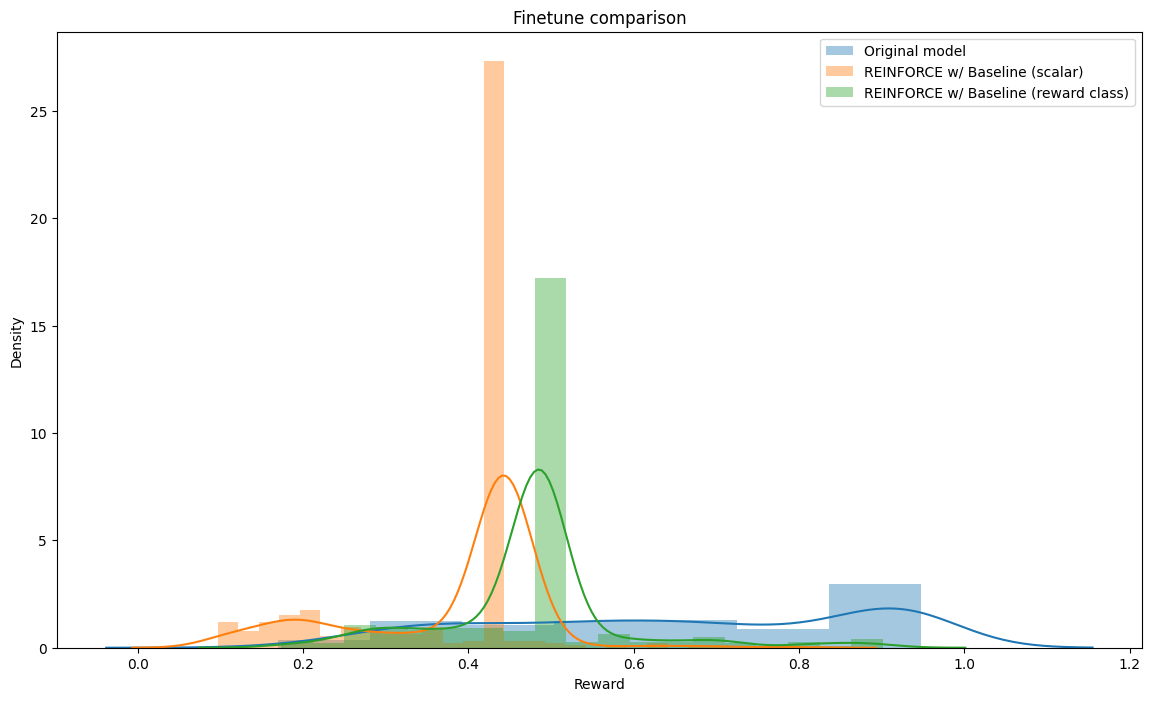

In [43]:
fig, ax = plt.subplots(figsize=(14,8))
sns.distplot(all_frozen_rewards, label='Original model')
sns.distplot(all_fitted_rewards, label='REINFORCE w/ Baseline (scalar)')
sns.distplot(all_fitted_rewards_multi, label='REINFORCE w/ Baseline (reward class)')
plt.title('Finetune comparison')
plt.xlabel('Reward')
plt.legend()
plt.show()

In [44]:
with torch.no_grad():
    del ref_model_multi
    del reward_model_multi
    clear_cache()

### Draft - Multi-reward with distribution over rewards

In [45]:
train_chosen = train_ds.map(lambda x: preprocess_ds_for_multi_distribution(x, 'chosen'), batched=True, remove_columns=train_ds.column_names)
train_rejected = train_ds.map(lambda x: preprocess_ds_for_multi_distribution(x, 'rejected'), batched=True, remove_columns=train_ds.column_names)
valid_chosen = valid_ds.map(lambda x: preprocess_ds_for_multi_distribution(x, 'chosen'), batched=True, remove_columns=train_ds.column_names)
valid_rejected = valid_ds.map(lambda x: preprocess_ds_for_multi_distribution(x, 'rejected'), batched=True, remove_columns=train_ds.column_names)
train_dl = DataLoader(concatenate_datasets([train_chosen, train_rejected]), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(concatenate_datasets([valid_chosen, valid_rejected]), batch_size=batch_size, shuffle=True)

Map:   0%|          | 0/7224 [00:00<?, ? examples/s]

Map:   0%|          | 0/7224 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

In [46]:
reward_model_distribution = AutoModelForSequenceClassification.from_pretrained(path_to_original_model
                                              , trust_remote_code=True
                                             , device_map='auto'
                                             , num_labels=num_labels
                                              , id2label={i:i+1 for i in range(num_labels)}
                                             , label2id={i+1:i for i in range(num_labels)}
                                                                               , torch_dtype=torch.float16
)
#
reward_model_distribution.config.pad_token_id = reward_model_distribution.config.eos_token_id
reward_model_distribution.eval()
reward_model_distribution.add_adapter(adapter_config=peft_config, adapter_name='multi_reward_lora_distribution')
reward_model_distribution = reward_model_distribution.to(torch.float32)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, reward_model_distribution.parameters()), lr=lr)

In [ ]:
for epoch in range(1):
    for line in tqdm(train_dl):
        optim.zero_grad()
        x = tokenizer(line['text'], padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        y_pred = reward_model_distribution(**x).logits
        loss = loss_fn(y_pred, torch.vstack(line['labels']).T.to(device))
        loss.backward()
        optim.step()




  7%|▋         | 66/903 [00:31<06:38,  2.10it/s]

In [ ]:
tmp_loss = []
with torch.no_grad():
    for line in tqdm(valid_dl):
        x = tokenizer(line['text'], padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        y_pred = reward_model_distribution(**x).logits
        loss = loss_fn(y_pred, torch.vstack(line['labels']).T.to(device))
        tmp_loss.append(loss)
print('eval loss multi dstribution', sum(tmp_loss)/len(tmp_loss))

In [ ]:
try:
    reward_model_distribution.to(torch.float16).save_pretrained(save_folder+"smollm-rm-multi-distribution")
    with torch.no_grad():
        del reward_model_distribution
        clear_cache()
    reward_model_distribution = AutoModelForSequenceClassification.from_pretrained(save_folder+"smollm-rm-multi-distribution"
                                              , trust_remote_code=True
                                             , device_map='auto'
                                             , num_labels=num_labels
                                              , id2label={i:i+1 for i in range(num_labels)}
                                             , label2id={i+1:i for i in range(num_labels)}
                                                                                   , torch_dtype=torch.float16
)
    reward_model_distribution.config.pad_token_id = reward_model_distribution.config.eos_token_id
    reward_model_distribution.eval()
    reward_model_distribution = reward_model_distribution.to(torch.float32)

except Exception as e:
    print('model is not saved:', e)

#### finetune with reward model

In [ ]:
ref_model_for_finetune_distribution = deepcopy(frozen_model)
ref_model_for_finetune_distribution.config.pad_token_id = ref_model_for_finetune_distribution.config.eos_token_id
z.train()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, ref_model_for_finetune_distribution.parameters()), lr=lr)

In [ ]:
with torch.no_grad():
    del prev_scores
    clear_cache()

In [ ]:
with torch.no_grad():
    del frozen_model
    clear_cache()

In [ ]:
with torch.no_grad():
    del x
    del y_pred
    del y_pred_sequences
    del y_pred_texts
    del reward_tok
    del reward_logits
    del reward_probs
    del y_pred_rewards
    del gathered_scores
    del loss
    clear_cache()

In [ ]:
prev_scores = []

for epoch in range(num_train_epochs):
    for line in tqdm(train_dl):
        optimizer.zero_grad()
        x = tokenizer(line['text'], padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)

        y_pred = ref_model_for_finetune_distribution(**x, output_scores=True).logits
        y_pred = nn.functional.log_softmax(y_pred, dim=-1)

        y_pred_sequences = y_pred.argmax(dim=-1)
        y_pred_texts = tokenizer.batch_decode(y_pred_sequences, skip_special_tokens=True)

        reward_tok = tokenizer(y_pred_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        reward_logits = reward_model_distribution(**reward_tok).logits
        prev_scores += reward_logits.tolist()
        reward_logits -= torch.tensor(prev_scores).mean(dim=0).to(device) ### subtracting baseline from current rewards
        reward_probs = torch.softmax(reward_logits, dim=-1)
        y_pred_rewards = torch.distributions.categorical.Categorical(reward_probs).sample()

        gathered_scores = torch.gather(y_pred, dim=2, index=y_pred_sequences[:, :len(y_pred)].T.unsqueeze(-1)).squeeze(-1)

        # loss = loss_fn(torch.sum(gathered_scores, dim=-1)*y_pred_rewards_loo, torch.sum(gathered_scores, dim=-1)) #torch.ones(len(y_pred)-1, device=device)

        loss = torch.sum(gathered_scores, dim=-1)*y_pred_rewards

        loss.sum().backward()
        optimizer.step()

        
        with torch.no_grad():
            del x
            del y_pred
            del y_pred_sequences
            del y_pred_texts
            del reward_tok
            del reward_logits
            del reward_probs
            del y_pred_rewards
            del gathered_scores
            del loss
            clear_cache()
        

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
with torch.no_grad():
    all_fitted_rewards_multi_distribution = evaluate_models(ref_model_for_finetune_distribution
                                                            , DataLoader(valid_ds, batch_size=batch_size, shuffle=True))

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
sns.distplot(all_frozen_rewards, label='Original model')
sns.distplot(all_fitted_rewards, label='REINFORCE w/ Baseline (scalar)')
sns.distplot(all_fitted_rewards_multi, label='REINFORCE w/ Baseline (reward class)')
sns.distplot(all_fitted_rewards_multi_distribution, label='REINFORCE w/ Baseline (reward distribution over classes)')
plt.title('Finetune comparison')
plt.xlabel('Reward')
plt.legend()
plt.show()